In [1]:
%load_ext autoreload
import sys
sys.path.append("../..")

# Helium

In [17]:
%autoreload

import numpy as np

%matplotlib inline

import matplotlib
matplotlib.rc_file('matplotlibrc')
matplotlib.rcParams['figure.figsize'] = [8,6]
import matplotlib.pyplot as plt




import darkhistory.physics as phys
import darkhistory.history.tla as tla

from astropy.io import fits

from scipy.interpolate import interp1d
from scipy.misc import derivative

In [3]:
print(phys.photo_ion_xsec(phys.He_exc_eng['21p'], 'HI'))
print(6.3e-18*(phys.He_exc_eng['21p']/phys.rydberg)**(-3))

# phys.ele_rad

1.8769945159245064e-18
1.6610693655433998e-18


## TLA with Helium

The TLA with helium looks like the following set of equations (from astro-ph/9909275):

$$ \frac{dx_\text{p}}{dz} = \mathcal{C}_\text{H} \left(x_\text{e} x_\text{p} n_\text{H} \alpha_\text{H} - \beta_\text{H} (1 - x_p) e^{- \nu_{\text{H} 2s} / T_M} \right)$$

$$ \frac{dx_\text{HeII}}{dz} = \mathcal{C}_\text{He} \left( 
    x_e x_\text{HeII} n_\text{H} \alpha_\text{HeI} - \beta_\text{HeI} \left( f_\text{He} - x_\text{HeII} \right) e^{- \nu_{\text{HeI 2}^1s} / T_M} \right) $$
    
where

$$\mathcal{C}_\text{H} = \frac{1 + K_\text{H} \Lambda_\text{H} n_\text{H} (1 - x_p)}{H(z) (1+z) \left( 1 + K_\text{H} (\Lambda_\text{H} + \beta_\text{H}) n_\text{H} (1 - x_p) \right)} $$

and similarly

$$\mathcal{C}_\text{He} = \frac{1 + K_\text{HeI} \Lambda_\text{He} n_\text{H} \left(f_\text{He} - x_\text{HeII} \right) e^{-\nu_\text{ps}/T_M}}{H(z) (1+z) \left( 1 + K_\text{HeI} (\Lambda_\text{He} + \beta_\text{HeI}) n_\text{H} (f_\text{He} - x_\text{HeII}) e^{- \nu_\text{ps}/T_M} \right)} $$

$\mathcal{C}_\text{H}$ should be the Peebles-C factor that we already have (we will check this numerically below), while $\mathcal{C}_\text{He}$ is the equivalent factor for helium.

Let's try to obtain the solution to these equations, together with the usual temperature evolution equations.

First, let's check that our Peebles-C factor expressions are the same. Note that there is a factor of 4 difference in our definition of $\beta$, and also the factor of $H(z) (1+z)$ which converts between $dz$ and $dt$. Also, $\beta$ should be evaluated at $T_R$ as per the HyREC paper. 

In [4]:
def C_H(rs, xp):
    lambda_H_2p = 2*np.pi*phys.hbar*phys.c/phys.lya_eng
    K_H = lambda_H_2p**3/(8*np.pi*phys.hubble(rs))
    Lambda_H = 8.22458
    
    numer = 1 + K_H*Lambda_H*phys.nH*rs**3*(1 - xp)
    denom = numer + K_H*(1-xp)*phys.beta_ion(phys.TCMB(rs), 'HI')*4*phys.nH*rs**3
    
    return numer/denom/(phys.hubble(rs)*rs)


rs = 70
xp = .01
# Should be equal.
print(C_H(rs, xp))
print(phys.peebles_C(xp, rs)/phys.hubble(rs)/rs)

19730968027353.65
19730968027353.645


This check confirms that we can use the same code as in `physics` and `tla` to solve for the hydrogen part of recombination, as well as the temperature evolution of course. We now need to code up the helium side of things.

In [5]:
chi = phys.nHe/phys.nH

def alpha_HeI_recomb(T_m):
    
    q = 10**-16.744
    p = 0.711
    T_1 = 10**5.114 * phys.kB # in eV
    T_2 = 3. * phys.kB # in eV

#     q = 1.691e-18
#     p = 1.519
#     T_1 = 3.2026e4 * phys.kB
#     T_2 = 3. * phys.kB
    
    # in cm^3 s^-1
    return 1e6*q/(
        np.sqrt(T_m/T_2)
        *(1. + T_m/T_2)**(1.-p)
        *(1. + T_m/T_1)**(1.+p) 
    )

def beta_HeI_ion(T_rad):
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    
#     E2s = phys.He_ion_eng - 2*np.pi*phys.hbar*phys.c/60.1404e-7
    E2s = phys.He_ion_eng - 2*np.pi*phys.hbar*phys.c*166277.4403
    return 4*(
        (1/de_broglie_wavelength)**3
        * np.exp(-E2s/T_rad) * alpha_HeI_recomb(T_rad)
    )

def alpha_HeI_triplet(T):
    
    q = 10**(-16.306)
    T_2 = 3 # in K
    T_1 = 10**(5.114)
    p = 0.761
    
    T_in_K = T/phys.kB
    
    denom = np.sqrt(T_in_K/T_2) * (1 + T_in_K/T_2)**(1-p) * (1 + T_in_K/T_1)**(1+p)
    
    return q/denom * (100**3) # in cm^3 s^-1

def beta_HeI_triplet(T):
    
    lambda_HeI_23s = 1/1.5985597526e7 * 100 # cm, from CLASS
#     E_ion_from_23s = phys.He_ion_eng - (2*np.pi*phys.hbar)*phys.c/lambda_HeI_23s
    E_ion_from_23s = phys.He_ion_eng - (2*np.pi*phys.hbar)*phys.c*159855.9745
    fac = (2*np.pi*phys.me*T/(2*np.pi*phys.hbar*phys.c)**2)**(3/2)
    boltz = np.exp(-E_ion_from_23s/T)
    return (4/3)*alpha_HeI_triplet(T)*fac*boltz
    
def C_HeII(xHII, xHeII, rs):
    
    T = phys.TCMB(rs)
    A_2p = 1.798287e9
    lambda_HeI_21p = 58.4334e-9*100 # cm
    lambda_HeI_21s = 60.1404e-9*100 # cm
    E_ps = (2*np.pi*phys.hbar)*phys.c*(1/lambda_HeI_21p - 1/lambda_HeI_21s) # eV

    tauHe = 3*A_2p*phys.nH*rs**3*(chi - xHeII) * (lambda_HeI_21p**3)/(8*np.pi*phys.hubble(rs))

    pHe_s = (1. - np.exp(-tauHe))/tauHe

    gamma_numer = 3*A_2p*(chi - xHeII)*lambda_HeI_21p**2
    sigma = phys.photo_ion_xsec(2*np.pi*phys.hbar*phys.c/lambda_HeI_21p, 'HI')
    Delta_nu = (phys.c/lambda_HeI_21p)*np.sqrt(2*T/(3.9715*phys.mp))
    gamma_denom = 8*np.pi**(3/2)*sigma*Delta_nu*(1 - xHII)
    if xHII >= 1:
        gamma = np.inf
    else:
        gamma = gamma_numer/gamma_denom

    aHe = 0.36
    bHe = 0.86

    p_con_H = 1/(1 + aHe*gamma**bHe)
    K_HeI = (1/3)/(A_2p * (pHe_s + p_con_H) * phys.nH*rs**3*(chi - xHeII))

    Lambda_HeI = 51.3 #s^-1

    numer = 1 + K_HeI*Lambda_HeI*(phys.nH*rs**3)*(chi - xHeII)*np.exp(E_ps/T)
    denom = 1 + K_HeI*(Lambda_HeI + beta_HeI_ion(T))*(phys.nH*rs**3)*(chi - xHeII)*np.exp(E_ps/T)

    return numer/denom

def C_HeII_triplet(xHeII, rs):
        
    T = phys.TCMB(rs)

    A_2p_triplet = 177.58
    lambda_HeI_23p = 1/1.690871466e7 * 100 # cm, from CLASS
    lambda_HeI_23s = 1/1.5985597526e7 * 100 # cm, from CLASS

    E_ps_triplet = (2*np.pi*phys.hbar)*phys.c*(1/lambda_HeI_23p - 1/lambda_HeI_23s) # eV

    tauHe_t = 3*A_2p_triplet*phys.nH*rs**3*(chi - xHeII) * (lambda_HeI_23p**3)/(8*np.pi*phys.hubble(rs))
    pHe_t = (1. - np.exp(-tauHe_t))/tauHe_t

    CfHe_t = A_2p_triplet*pHe_t*np.exp(-E_ps_triplet/T);
    CfHe_t = CfHe_t/(beta_HeI_triplet(T) + CfHe_t)

    return CfHe_t

def C_He_old(rs, xHeII, T_m):
    
    lambda_HeI_2_1p = 58.4334e-7
    
    Lambda_He = 51.3
    
    f_He = phys.nHe/phys.nH
    
    K_HeI = lambda_HeI_2_1p**3/(8*np.pi*phys.hubble(rs))
    
    E_ps = -2*np.pi*phys.hbar*phys.c*(
        1./58.4334e-7 - 1./60.1404e-7
    )
    
    numer = 1. + K_HeI*Lambda_He*phys.nH*rs**3*(f_He - xHeII)*np.exp(-E_ps/T_m)
    denom = numer + K_HeI*beta_HeI_ion(phys.TCMB(rs))*phys.nH*rs**3*(f_He - xHeII)*np.exp(-E_ps/T_m)

    return numer/denom
    
    

In [6]:
def xe_Saha(rs, species):
    
    T = phys.TCMB(rs)
    
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * phys.me * T)
    )
    
    if species == 'HI':
        rhs = (1/de_broglie_wavelength)**3 / (phys.nH*rs**3) * np.exp(-phys.rydberg/T)
        a   = 1.
        b   = rhs
        c   = -rhs
    elif species == 'HeI':
        rhs = 4 * (1/de_broglie_wavelength)**3 / (phys.nH*rs**3) * np.exp(-phys.He_ion_eng/T)
        a = 1.
        b = -rhs*(-1.) - 1
        c = -(1 + phys.nHe/phys.nH)*rhs
    else:
        raise TypeError('Invalid species.')
    
    return (-b + np.sqrt(b**2 - 4*a*c))/(2*a)

def xe_Saha_HI(rs):
    
    if xe_Saha(rs, 'HI') > 0.999999:
        
        T = phys.TCMB(rs)
    
        de_broglie_wavelength = (
            phys.c * 2*np.pi*phys.hbar
            / np.sqrt(2 * np.pi * phys.me * T)
        )
        
        return 1. - 1/((1/de_broglie_wavelength)**3 / (phys.nH*rs**3) * np.exp(-phys.rydberg/T))
    
    else:
    
        return xe_Saha(rs, 'HI')
    
def xe_Saha_deriv_HI(rs):
    
    xe_s = xe_Saha_HI(rs)
    
    numer = (phys.rydberg/phys.TCMB(rs) - 3/2)*xe_s**2
    denom = rs*(2*xe_s + xe_s**2/(1 - xe_s))
    
    return numer/denom
    

def xe_Saha_HeI(rs):
    
    return xe_Saha(rs, 'HeI')

Now for the equivalent of `get_history`. 

In [7]:
from scipy.integrate import odeint

def compton_cooling_rate(xHII, xHeII, xHeIII, T_m, rs):

    xe = xHII + xHeII + 2*xHeIII

    return (
        4 * phys.thomson_xsec * 4 * phys.stefboltz / phys.me
        * xe * phys.nH*rs**3 * (phys.TCMB(rs) - T_m)
        * phys.TCMB(rs)**4
    )

def get_history_He(
    init_cond, f_H_ion_in, f_H_exc_in, f_heating_in, 
    dm_injection_rate_in, rs_vec, mxstep = 0
):

    def f_H_ion(rs, xHI, xHeI, xHeII):
        if isinstance(f_H_ion_in, float):
            return f_H_ion_in
        elif callable(f_H_ion_in):
            return f_H_ion_in(rs, xHI, xHeI, xHeII)
        else:
            raise TypeError('f_H_ion_in must be float or an appropriate function.')

    def f_H_exc(rs, xHI, xHeI, xHeII):
        if isinstance(f_H_exc_in, float):
            return f_H_exc_in
        elif callable(f_H_exc_in):
            return f_H_exc_in(rs, xHI, xHeI, xHeII)
        else:
            raise TypeError('f_H_exc_in must be float or an appropriate function.')

    def f_heating(rs, xHI, xHeI, xHeII):
        if isinstance(f_heating_in, float):
            return f_heating_in
        elif callable(f_heating_in):
            return f_heating_in(rs, xHI, xHeI, xHeII)
        else:
            raise TypeError('f_heating_in must be float or an appropriate function.')

    def dm_injection_rate(rs):
        if isinstance(dm_injection_rate_in, float):
            return dm_injection_rate_in
        elif callable(dm_injection_rate_in):
            return dm_injection_rate_in(rs)
        else:
            raise TypeError('dm_injection_rate_in must be a float or an appropriate function.')
            
    chi = phys.nHe/phys.nH
    
    def xHII(yHII):
            return 0.5 + 0.5*np.tanh(yHII)
    def xHeII(yHeII):
        return chi/2 + chi/2*np.tanh(yHeII)
    def xHeIII(yHeIII):
        return chi/2 + chi/2*np.tanh(yHeIII)
    
    def tla(var, rs):

        def dT_dz(yHII, yHeII, yHeIII, T_m, rs):

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            xHI = 1 - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            # This rate is temperature loss per redshift.
            adiabatic_cooling_rate = 2 * T_m/rs

            return adiabatic_cooling_rate + (
                - phys.dtdz(rs)*(
                    compton_cooling_rate(
                        xHII(yHII), xHeII(yHeII), xHeIII(yHeIII), T_m, rs
                    )
                    + f_heating(rs, xHI, xHeI, xHeII(yHeII)) * dm_injection_rate(rs)
                )
            )/ (3/2 * phys.nH*rs**3 * (1 + chi + xe))

        def dyHII_dz(yHII, yHeII, yHeIII, T_m, rs):

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0
            
            if xHeII(yHeII) > 0.99*chi:
                return 0
            
            if xHII(yHII) > 0.99 and rs > 1000:
                return 2 * np.cosh(yHII)**2 * xe_Saha_deriv_HI(rs)
            
            if yHII > 14 or yHII < -14:
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * phys.nH*rs**3
            xHI = 1. - xHII(yHII)
            xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)

            return 2 * np.cosh(yHII)**2 * -phys.dtdz(rs) * (
                # Recombination processes
                - phys.peebles_C(xHII(yHII), rs) * (
                    phys.alpha_recomb(T_m, 'HI') * xHII(yHII)*xe * phys.nH * rs**3
                    - 4*phys.beta_ion(phys.TCMB(rs), 'HI') * xHI
                        * np.exp(-phys.lya_eng/phys.TCMB(rs))
                )
                # DM injection. Note that C = 1 at late times.
                + f_H_ion(rs, xHI, xHeI, xHeII(yHeII)) * dm_injection_rate(rs)
                    / (phys.rydberg * phys.nH * rs**3)
                + (1 - phys.peebles_C(xHII(yHII), rs)) * (
                    f_H_exc(rs, xHI, xHeI, xHeII(yHeII)) * dm_injection_rate(rs)
                    / (phys.lya_eng * phys.nH * rs**3)
                )
            )

        def dyHeII_dz(yHII, yHeII, yHeIII, T_m, rs):
            
            lambda_HeI_21s = 60.1404e-9*100 # cm
            lambda_HeI_23s = 1/1.5985597526e7 * 100 # cm, from CLASS

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            
            if yHeII > 14 or yHeII < -15:
                return 0
            
            
            if xHeII(yHeII) > 0.99*chi:
                return 2/chi * np.cosh(yHeII)**2 * derivative(xe_Saha_HeI, rs)
            
            else:
                
                term_recomb = xHeII(yHeII) * xe * (phys.nH * rs**3) * alpha_HeI_recomb(T_m)
                term_ion    = (
                    beta_HeI_ion(phys.TCMB(rs)) * (chi - xHeII(yHeII)) 
                    * np.exp(-(2*np.pi*phys.hbar*phys.c/lambda_HeI_21s)/T_m)
                )

                term_recomb_triplet = xHeII(yHeII) * xe * (phys.nH * rs**3) * alpha_HeI_triplet(T_m)
                term_ion_triplet    = (
                    3*beta_HeI_triplet(phys.TCMB(rs)) 
                    * (chi - xHeII(yHeII)) * np.exp(-(2*np.pi*phys.hbar*phys.c/lambda_HeI_23s)/T_m)
                )
                
                return 2/chi * np.cosh(yHeII)**2 * -phys.dtdz(rs) * (
                    -C_HeII(xHII(yHII), xHeII(yHeII), rs) * (term_recomb - term_ion)
                    -C_HeII_triplet(xHeII(yHeII), rs) *(term_recomb_triplet - term_ion_triplet)
                )


#                 E_HeI21s = 2*np.pi*phys.hbar*phys.c/60.1404e-7

#                 xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
#                 ne = xe * phys.nH*rs**3
#                 xHeI = chi - xHeII(yHeII) - xHeIII(yHeIII)
                

#                 return 2/chi * np.cosh(yHeII)**2 * -phys.dtdz(rs) * (
#                     -C_He(rs, xHeII(yHeII), T_m) * (
#                         alpha_HeI_recomb(T_m) * xHeII(yHeII) * xe * phys.nH * rs**3
#                         - beta_HeI_ion(phys.TCMB(rs)) * xHeI *np.exp(-E_HeI21s/T_m)
#                     )
#                 )

        def dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs):

            if 1 - xHII(yHII) < 1e-6 and rs < 100:
                # At this point, leave at 1 - 1e-6
                return 0

            xe = xHII(yHII) + xHeII(yHeII) + 2*xHeIII(yHeIII)
            ne = xe * phys.nH*rs**3

            return 0

        T_m, yHII, yHeII, yHeIII = var[0], var[1], var[2], var[3]
        
        return [
            dT_dz(yHII, yHeII, yHeIII, T_m, rs),
            dyHII_dz(yHII, yHeII, yHeIII, T_m, rs),
            dyHeII_dz(yHII, yHeII, yHeIII, T_m, rs),
            dyHeIII_dz(yHII, yHeII, yHeIII, T_m, rs)
        ]

    if init_cond[1] == 1:
        init_cond[1] = 1 - 1e-12
#         print(rs_vec[0])
#         print(xe_Saha_HI(rs_vec[0]))
#         init_cond[1] = xe_Saha_HI(rs_vec[0])
    if init_cond[2] == 0:
        init_cond[2] = 1e-12
    elif init_cond[2] == phys.nHe/phys.nH:
        init_cond[2] = phys.nHe/phys.nH - 1e-6
    if init_cond[3] == 0:
        init_cond[3] = 1e-12

    init_cond[1] = np.arctanh(2*(init_cond[1] - 0.5))
    init_cond[2] = np.arctanh(2/chi * (init_cond[2] - chi/2))
    init_cond[3] = np.arctanh(2/chi *(init_cond[3] - chi/2))

    soln = odeint(
        tla, init_cond, rs_vec, rtol=1e-4, mxstep = mxstep
    )
    
    soln[:,1] = 0.5 + 0.5*np.tanh(soln[:,1])
    soln[:,2] = (
        chi/2 + chi/2*np.tanh(soln[:,2])
    )
    soln[:,3] = (
        chi/2 + chi/2*np.tanh(soln[:,3])
    )

    return soln


In [8]:
rs_start = 3000
rs_vec_std = np.flipud(1. + np.arange(0, rs_start, 0.1))

init_cond = [phys.TCMB(rs_start), xe_Saha_HI(rs_start), xe_Saha_HeI(rs_start) - 1., 0]

soln = get_history_He(init_cond, 0., 0., 0., 0., rs_vec_std, mxstep=1000)
rs_vec_std = np.flipud(1 + np.arange(1, rs_start, 0.1))
init_cond = [phys.TCMB(rs_start), 1., phys.nHe/phys.nH*0, 0]
# soln_DH = tla.get_history(init_cond, 0., 0., 0., 0., rs_vec_std, reion_switch=False)



In [9]:
# Compare with RECFAST results from CLASS
direc = '/Users/hongwan/Desktop/'

xe_recfast = np.loadtxt(direc+'recfast_xe.txt')


xe_recfast_func = interp1d(1+xe_recfast[0,:], xe_recfast[1,:], bounds_error=False, fill_value=(xe_recfast[1,-1], xe_recfast[1,0]))

ValueError: x and y must have same first dimension, but have shapes (29990,) and (30000,)

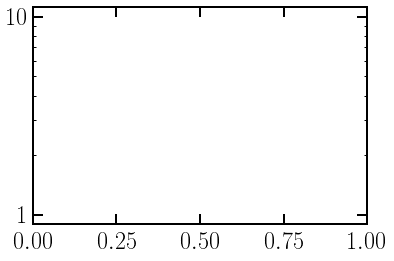

In [10]:
plt.figure()

# plt.loglog()

ax = plt.gca()
ax.set_yscale('log')

plt.plot(rs_vec_std, soln[:,1])
# plt.plot(rs_vec_std, xH_idl_func(rs_vec_std), ':')

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_\mathrm{HII}$')

plt.figure()

plt.axis([0, 2000, 0, 1.1])

# plt.loglog()
ax = plt.gca()
ax.set_yscale('log')

plt.plot(rs_vec_std, soln[:,2]*phys.nH/phys.nHe)
# plt.plot(rs_vec_std, xHe_idl_func(rs_vec_std), ':')
# plt.plot(rs_vec_std, ((xe_Saha(rs_vec_std) - 1)*phys.nH/phys.nHe))

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$n_\mathrm{HeII}/n_\mathrm{He}$')

plt.axis([1, 3000, 1e-15, 1.1])

plt.figure()

# plt.loglog()

plt.plot(rs_vec_std, soln[:,1] + soln[:,2])
plt.plot(rs_vec_std, xe_recfast_func(rs_vec_std), ':')
# plt.plot(rs_vec_std, ((xe_Saha(rs_vec_std) - 1)*phys.nH/phys.nHe))

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_e$')

plt.axis([1000, 3000, .95, 1.1])

plt.figure()

# plt.loglog()

ax = plt.gca()
ax.set_yscale('log')

plt.plot(rs_vec_std, soln[:,1] + soln[:,2])
plt.plot(rs_vec_std, xe_recfast_func(rs_vec_std), ':')
# plt.plot(rs_vec_std, ((xe_Saha(rs_vec_std) - 1)*phys.nH/phys.nHe))

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_e$')

plt.axis([0, 1500, -0.1, 1.1])

plt.figure()

# plt.loglog()

ax = plt.gca()

plt.plot(rs_vec_std, (soln[:,1] + soln[:,2])/xe_recfast_func(rs_vec_std) - 1)

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_{e,\mathrm{DH}}/x_{e,\mathrm{RECFAST}} - 1$')

plt.axis([0, 3000, -0.1, 0.1])

In [64]:
%autoreload

rs_start = 3000
rs_vec_std = np.flipud(0. + np.arange(1, rs_start+1))

init_cond = [phys.TCMB(rs_start), xe_Saha_HI(rs_start), xe_Saha_HeI(rs_start) - 1., 0]

soln = get_history_He(init_cond, 0., 0., 0., 0., rs_vec_std, mxstep=1000)
init_cond = [phys.TCMB(rs_start), phys.xe_Saha(rs_start, 'HI'), phys.xe_Saha(rs_start, 'HeI') - 1., 0]
# init_cond = [phys.TCMB(rs_start), phys.xe_Saha(rs_start, 'HI'), 0., 0]
soln_DH = tla.get_history(init_cond, 0., 0., 0., 0., rs_vec_std, reion_switch=False, helium_TLA=True, mxstep=1000)


[2000, 3000, -0.1, 0.1]

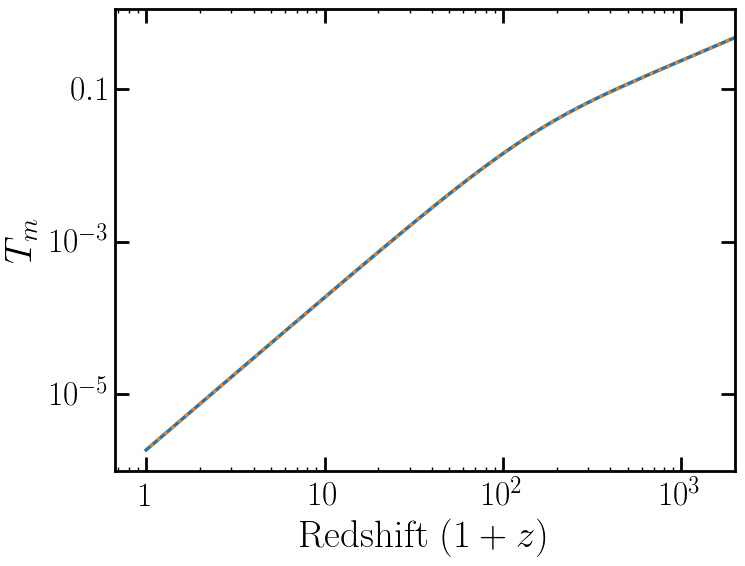

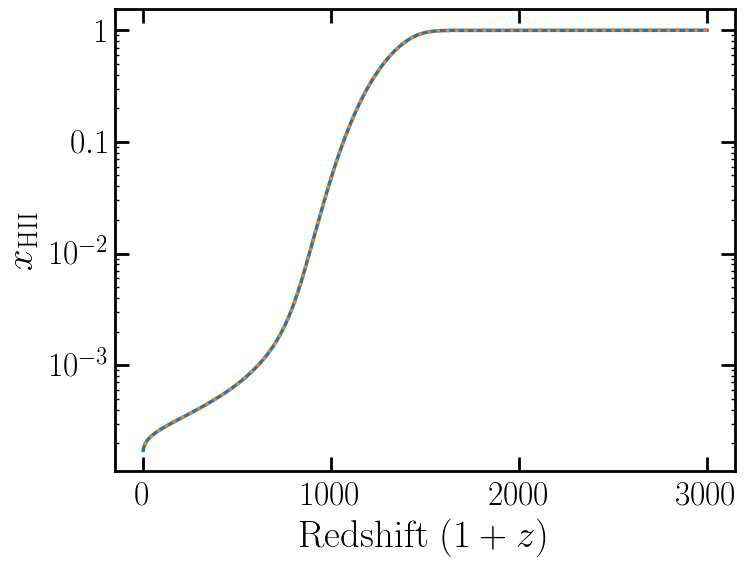

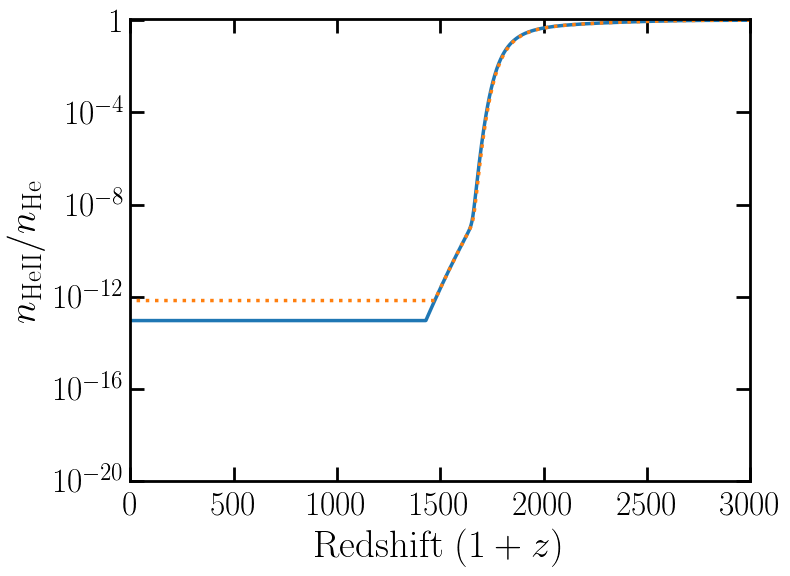

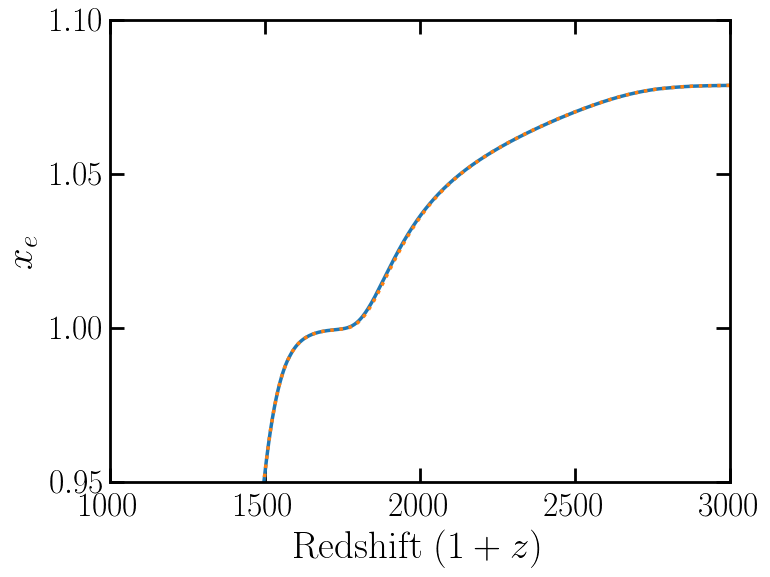

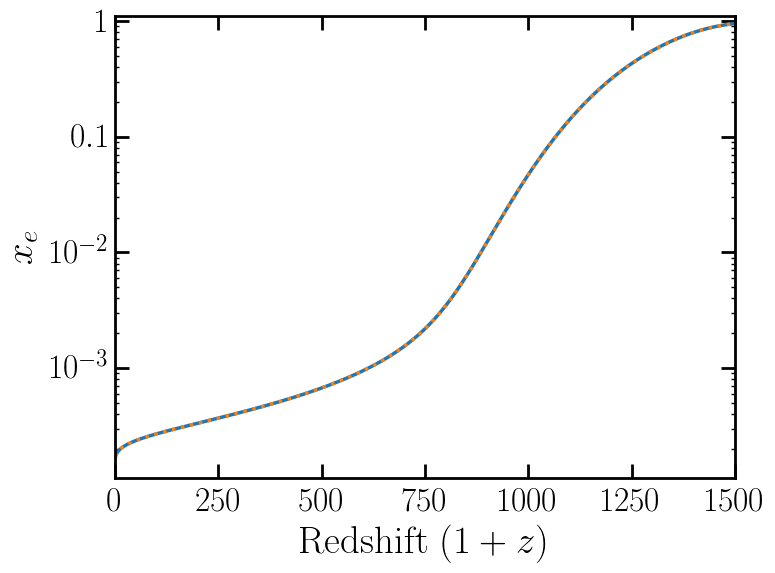

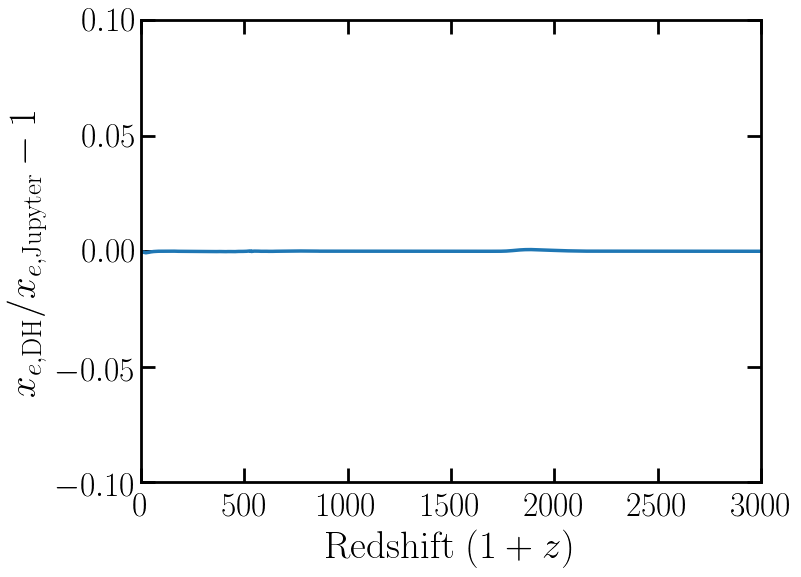

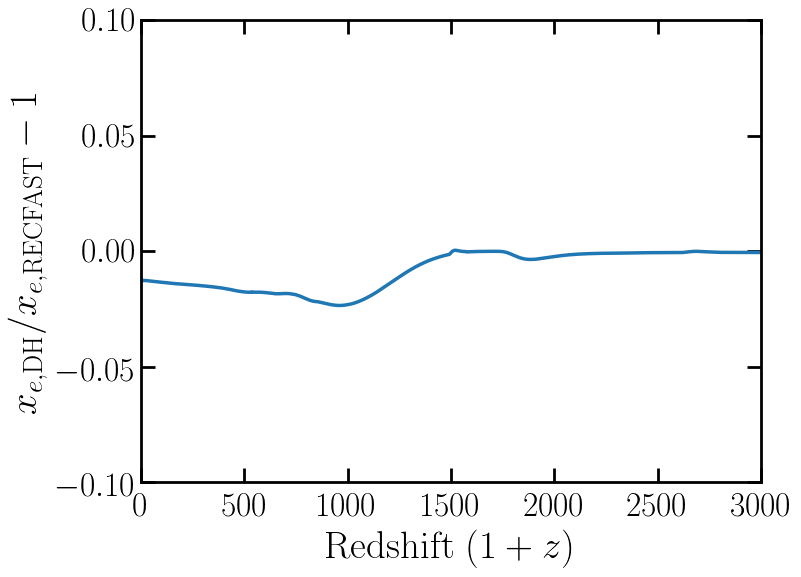

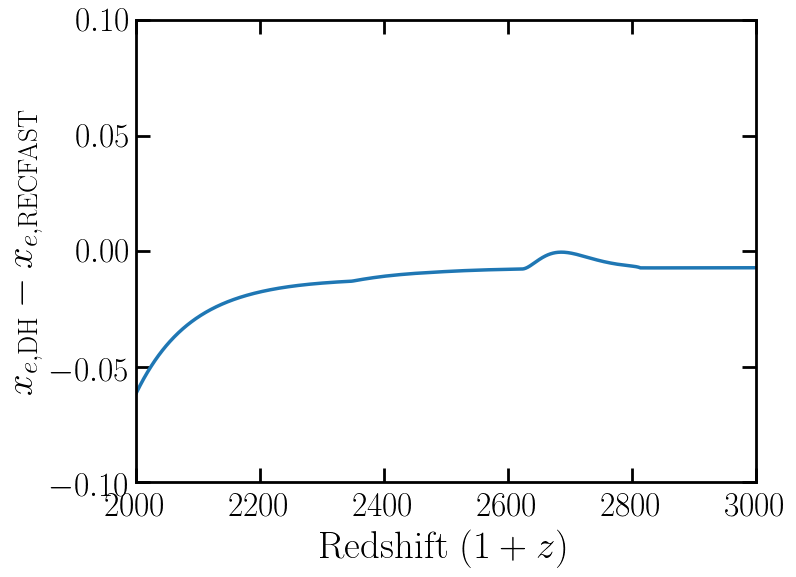

In [65]:
plt.figure()

# plt.loglog()

ax = plt.gca()
ax.loglog()

plt.plot(rs_vec_std, soln[:,0])
plt.plot(rs_vec_std, soln_DH[:,0], ':')

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$T_m$')


plt.axis([0, 2000, 0, 1.1])

plt.figure()

# plt.loglog()

ax = plt.gca()
ax.set_yscale('log')

plt.plot(rs_vec_std, soln[:,1])
plt.plot(rs_vec_std, soln_DH[:,1], ':')

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_\mathrm{HII}$')

plt.figure()

plt.axis([0, 2000, 0, 1.1])

# plt.loglog()
ax = plt.gca()
ax.set_yscale('log')

plt.plot(rs_vec_std, soln[:,2]*phys.nH/phys.nHe)
plt.plot(rs_vec_std, soln_DH[:,2]*phys.nH/phys.nHe, ':')
plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$n_\mathrm{HeII}/n_\mathrm{He}$')

plt.axis([1, 3000, 1e-20, 1.1])

plt.figure()

# plt.loglog()

plt.plot(rs_vec_std, soln[:,1] + soln[:,2])
plt.plot(rs_vec_std, soln_DH[:,1] + soln_DH[:,2], ':')
# plt.plot(rs_vec_std, ((xe_Saha(rs_vec_std) - 1)*phys.nH/phys.nHe))

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_e$')

plt.axis([1000, 3000, .95, 1.1])

plt.figure()

# plt.loglog()

ax = plt.gca()
ax.set_yscale('log')

plt.plot(rs_vec_std, soln[:,1] + soln[:,2])
plt.plot(rs_vec_std, soln_DH[:,1] + soln_DH[:,2], ':')
# plt.plot(rs_vec_std, ((xe_Saha(rs_vec_std) - 1)*phys.nH/phys.nHe))

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_e$')

plt.axis([0, 1500, -0.1, 1.1])

plt.figure()

# plt.loglog()

ax = plt.gca()

plt.plot(rs_vec_std, (soln[:,1] + soln[:,2])/(soln_DH[:,1] + soln_DH[:,2]) - 1)

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_{e,\mathrm{DH}}/x_{e,\mathrm{Jupyter}} - 1$')

plt.axis([0, 3000, -0.1, 0.1])

plt.figure()

# plt.loglog()

ax = plt.gca()

plt.plot(rs_vec_std, (soln_DH[:,1] + soln_DH[:,2])/xe_recfast_func(rs_vec_std) - 1)

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_{e,\mathrm{DH}}/x_{e,\mathrm{RECFAST}} - 1$')

plt.axis([0, 3000, -0.1, 0.1])

plt.figure()

# plt.loglog()

ax = plt.gca()

plt.plot(rs_vec_std, soln_DH[:,2]/(xe_recfast_func(rs_vec_std) - 1.) - 1.)

plt.xlabel(r'Redshift $(1+z)$')
plt.ylabel(r'$x_{e,\mathrm{DH}} - x_{e,\mathrm{RECFAST}}$')

plt.axis([2000, 3000, -0.1, 0.1])

In [ ]:
import pickle

soln_output = np.array([rs_vec_std, soln_DH[:,0], soln_DH[:,1], soln_DH[:,2]])
print(rs_vec_std)
pickle.dump(soln_output, open('/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln_He.p', 'wb'))

In [ ]:
test = pickle.load(open('/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln.p', 'rb'))

plt.figure()
plt.loglog()

print(np.transpose([soln_output[0,:], soln_output[3,:]]))
print('blah')
print(np.transpose([test[0,:], test[1,:]]))

plt.plot(soln_output[0,:], soln_output[1,:])
plt.plot(test[0,:], test[1,:], ':')

## Helium $f(z)$

In [ ]:
from darkhistory.low_energy import lowE_photons
from darkhistory.spec.spectrum import Spectrum

In [ ]:
# Note that MEDEA assumes that He and H have the same ionization levels...

%autoreload
photeng = 10**np.arange(-4, 12, 0.5)
photspec = Spectrum(photeng, np.ones_like(photeng))

rs = 1000
tau = 1e25

chi = phys.nHe/phys.nH

x = np.array([0.9, 0.9*chi, 0.1*chi])
dE_dVdt = rs**3*phys.rho_DM/tau 
dt = 0.001/phys.hubble(rs)
norm_fac = phys.nB*rs**3/dt/dE_dVdt

a = lowE_photons.getf_ion(photspec, norm_fac, x*phys.nH*rs**3, method='old')
b = lowE_photons.getf_ion(photspec, norm_fac, x*phys.nH*rs**3, method='helium')


In [ ]:
print(a)
print(b)
print(b[0] + b[1]*phys.rydberg/phys.He_ion_eng)

In [ ]:
plt.figure()

plt.plot(rs_vec_std, C_He(rs_vec_std, soln[:,2], phys.TCMB(rs_vec_std)))

In [ ]:
C_He(2000, phys.nHe/phys.nH - 1e-6, 1)

In [ ]:
phys.nHe/phys.nH - soln[:,2]

In [ ]:
soln[:,2]*phys.nH/phys.nHe

In [ ]:
xe_Saha_HeI(3000)

In [ ]:
lambda_HeI_23p = 1/1.690871466e7 * 100 # cm, from CLASS
lambda_HeI_23s = 1/1.5985597526e7 * 100
print(lambda_HeI_23p, lambda_HeI_23s)

In [ ]:
%autoreload
T = 0.1
print(alpha_HeI_triplet(T))
print(phys.alpha_recomb(T, 'HeI_23s'))
print(alpha_HeI_recomb(T))
print(phys.alpha_recomb(T, 'HeI_21s'))
print(beta_HeI_ion(T))
print(phys.beta_ion(T, 'HeI_21s'))
print(beta_HeI_triplet(T))
print(phys.beta_ion(T, 'HeI_23s'))

In [ ]:
E2s = phys.He_ion_eng - 2*np.pi*phys.hbar*phys.c/60.1404e-7
print(E2s, phys.He_ion_eng - phys.He_exc_eng('21s'))

In [ ]:
print(
    phys.He_ion_eng - 2*np.pi*phys.hbar*phys.c*1.5985597526e5,
    phys.He_ion_eng - phys.He_exc_eng('23s'))




In [ ]:
2*np.pi*phys.hbar*phys.c*1.5985597526e5

In [ ]:
def beta_HeI_ion(T_rad):
    reduced_mass = phys.mp*phys.me/(phys.mp + phys.me)
    de_broglie_wavelength = (
        phys.c * 2*np.pi*phys.hbar
        / np.sqrt(2 * np.pi * reduced_mass * T_rad)
    )
    
#     E2s = phys.He_ion_eng - 2*np.pi*phys.hbar*phys.c/60.1404e-7
    E2s = phys.He_ion_eng - 2*np.pi*phys.hbar*phys.c*166277.4403
#     print(E2s)
#     print(de_broglie_wavelength)
    return 4*(
        (1/de_broglie_wavelength)**3
        * np.exp(-E2s/T_rad) * alpha_HeI_recomb(T_rad)
    )

In [ ]:
%autoreload
print(beta_HeI_ion(1))
print(phys.beta_ion(1, 'HeI_21s'))

In [ ]:
%autoreload
test_rs = 9000

print(phys.xe_Saha(test_rs, 'HeI'))
print(xe_Saha_HeI(test_rs))


print(phys.d_xe_Saha_dz(test_rs, 'HeI'))
def test(rs):
    
    return phys.xe_Saha(rs, 'HeI')

print(derivative(test, test_rs))
derivative(xe_Saha_HeI,test_rs)

In [ ]:
%autoreload
xHII = 0.89
xHeII = 0.999*phys.chi
rs = 3000
print(phys.C_He(xHII, xHeII, rs, 'singlet'))
print(C_HeII(xHII, xHeII, rs))
print(phys.C_He(xHII, xHeII, rs, 'triplet'))
print(C_HeII_triplet(xHeII, rs))

In [ ]:
from scipy.special import expi
expi(3)

In [30]:
soln_DH[:,2]/(xe_recfast_func(rs_vec_std) - 1.)

array([ 9.92864518e-01,  9.92864397e-01,  9.92864276e-01, ...,
       -5.44872105e-14, -5.44870129e-14, -5.44867880e-14])

In [32]:
xe_recfast_func(rs_vec_std) - 1.

array([ 0.07942631,  0.07942533,  0.07942434, ..., -0.99981731,
       -0.99982093, -0.99982506])

In [70]:
rs = 4

phys.nH*rs**3*phys.photo_ion_xsec(24.6, 'HI')*phys.c/phys.hubble(rs)

45262.68646972105